In [65]:
#Dataset: https://data.csail.mit.edu/graphics/fivek/

#Take the image and the Semantic information about each photo and train a model to predict the semantic information about each photo
#X: the image Y: the semantic information (multi-label classification)

#Useful links:
#https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html
#https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html
#https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
#https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#https://www.tensorflow.org/guide/tensor
#https://docs.pytorch.org/tutorials/beginner/introyt/tensors_deeper_tutorial.html
#https://www.geeksforgeeks.org/deep-learning/how-to-split-a-dataset-using-pytorch/
#https://docs.pytorch.org/vision/stable/transforms.html
#https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html
#https://docs.pytorch.org/vision/master/_modules/torchvision/io/image.html#decode_image
#https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.functional.multilabel_accuracy.html#torcheval.metrics.functional.multilabel_accuracy

In [66]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image, decode_image
import rawpy
import matplotlib.pyplot as plt
import PIL
from torchvision.utils import make_grid
import torch.nn.functional as F
from datetime import datetime

In [67]:
#Import the dataset
df = pd.read_csv('categories.csv')

In [68]:
#One-hot encode labels to make them numeric - pyTorch functional F.one_hot requires numeric labels so we will use pandas to encode the labels
df = pd.get_dummies(df, columns=df.columns[1:], dtype="int") #New pandas defaults to bool for dummies, we need int for pytorch
print(df.head())

                   img_name  location_indoor  location_outdoor  \
0        a0001-jmac_DSC1459                0                 1   
1             a0002-dgw_005                1                 0   
2        a0003-NKIM_MG_8178                0                 1   
3        a0004-jmac_MG_1384                0                 1   
4  a0005-jn_2007_05_10__564                0                 1   

   location_unknown  time_of_day_day  time_of_day_dusk  time_of_day_night  \
0                 0                1                 0                  0   
1                 0                1                 0                  0   
2                 0                1                 0                  0   
3                 0                1                 0                  0   
4                 0                1                 0                  0   

   time_of_day_unknown  skyCondition_artificial  skyCondition_mixed  \
0                    0                        0                   0  

In [69]:
class CategoryDataset(Dataset):
    def __init__(self,csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.image_dir = image_dir # Directory where images are stored

        #Get the boundaries of the directories first
        self.directory_boundaries = []
        self.directories = os.listdir(self.image_dir)
        removed_from_original = 0
        for i,directory in enumerate(self.directories[:]): # Use a copy of the list to losing track of indices while modifying the list
            if not directory.startswith('HQa'):
                self.directories.pop(i-removed_from_original) # - removed_from_original because we are removing items from the list, so the index shifts to the left
                removed_from_original += 1
                continue  # Skip directories that do not start with 'HQa'

            bound_1 = directory.split('HQa')[1].split('to')[0]  # After 'HQa' and before '-'
            bound_2 = directory.split('to')[1] # After 'to'
            self.directory_boundaries.append((int(bound_1), int(bound_2)))

    def dng_to_numpy(self, image_path):
        with rawpy.imread(image_path) as raw:
            # Convert the raw image to a numpy array (numpy format)
            return raw.postprocess(use_camera_wb=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_name = row['img_name']  # Assuming the first column is the image name
        #Get the image
        image_number  = int(image_name.split('a')[1].split('-')[0]) #After the 'a' and before the '-'
        all_labels = df[df.columns[1:]].values #df needs columns to know which columns to use for labels, we assume the first column is the image name, hence df.columns[1:]
        label = torch.tensor(all_labels[idx], dtype=torch.float32)  # Get the labels for the current image from the dataframe
        for bounds in self.directory_boundaries:
            #Had to change folder name from 'Hqa1400to1400' to 'HQa1401to2100' because otherwise the bounds depends on the order of the directories in the list due to dupe with 'Hqa701to1400', which is not guaranteed to be the same every time
            if not bounds[0] <= image_number <= bounds[1]:
                continue
            directory = self.directories[self.directory_boundaries.index(bounds)] #Because the directories are in the same order as the boundaries
            image = os.path.join(self.image_dir, directory + "/photos/", row['img_name'] + ".dng")
            if not os.path.exists(image):
                raise FileNotFoundError(f"Image {image} not found in any directory.")
            # Load the image
            image = self.dng_to_numpy(image) # Convert the raw image to a numpy array so that our ToPILImage transform can work with it
            if self.transform:
                image = self.transform(image)
            return image, label

In [70]:
dataset = CategoryDataset(
    csv_file='categories.csv',
    image_dir='raw_photos/raw_photos/',
    #Transforms get applied after data is loaded, so these use transforms are applied to the numpy array outputted from our CategoryDataset class (which is a raw image converted to numpy array using dng_to_numpy method)
    transform=transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL Image
        transforms.Resize((512, 512)),  # Resize to a fixed size (makes all tensors the same shape)
        transforms.ToTensor(),  # Convert PIL Image to tensor - This is required for PyTorch models
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the tensor (imagenet standard normalization)
    ])
)

FileNotFoundError: [Errno 2] No such file or directory: 'raw_photos/raw_photos/'

In [7]:
#Enable GPU for colab if found
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [8]:
#Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #split the dataset into training and test sets

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

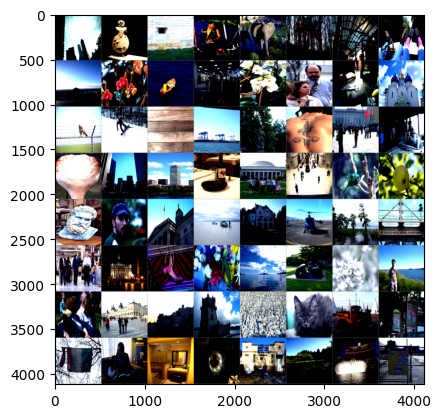

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Get a batch of images and labels

# show images
imshow(make_grid(images))

In [10]:
#Shape of the images - images without [] will be batch size x channels x height x width
print(images[0].shape)  # Should be in the format (C, H, W) where C is channels, H is height, W is width - 512 columns, 512 rows, 3 channels (RGB)

#Check the labels
print(len(labels))
print(len(labels[0]))

torch.Size([3, 512, 512])
64
15


In [11]:
#For the maths: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
#in_channels: Number of channels in the input image (3 for RGB)
#out_channels: Number of channels produced by the convolution (number of filters)
#kernel_size: Size of the convolving kernel (filter) - 5x5 in this case
#stride: Stride of the convolution (1 by default, meaning the filter moves one pixel at a time)
#padding: Zero-padding added to both sides of the input (0 by default, meaning no padding)
#in_features: Number of input features for the fully connected layer (flattened output of the convolutional layers)
#out_features: Number of output features for the fully connected layer (number of classes or labels in multi-label classification)
#Linear layer is the same as Dense layer in Keras or TensorFlow
#Activiation functions are applied in the forward function.


#Increase conv2d output channels to increase the complexity of the model, we are underfitting we will need to redo calculations for the output size after each convolution and pooling layer

#Network was increased in size and complexity to improve performance, we are underfitting with the original architecture

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        #Images are 512x512 pixels, 3 channels (RGB), we will use convolutional layers to extract features from the images
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7) #3 in channels because we have RGB images, 32 out channels means we will have 32 feature maps (channels) after the convolution

        #Output size calculation: (512 (input size) - 7 (kernel size) / 1 (stride))  + 1 (padding) = 506
        #Shape after conv1: (12, 506, 506)

        self.pool = nn.MaxPool2d(2, 2) #Takes the highest value from 2x2 windows, reducing the size by half. 2x2 window means the output size is halved
        #Shape after pool1: (12, 253, 253) - this wil be called during forward function, so we don't need to calculate it here

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) #Remember we now have 32 feature maps (channels) from the previous layer
        #Output size: (253 (input size) - 3 (kernel size) / 1 (stride)) + 1 (padding) = 251 - shape: (12, 251, 251)

        # pooling layer will be applied after this convolution in forward function -> shape after second pooling: (24, 125, 125)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) #Remember we now have 64 feature maps (channels) from the previous layer
        #Output size: (125 (input size) - 3 (kernel size) / 1 (stride)) + 1 (padding) = 123 , shape: (24, 123, 123) -

        # pooling layer will be applied after this convolution in forward function -> shape after third pooling: (24, 61, 61)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3) #Remember we now have 64 feature maps (channels) from the previous layer
        #Output size: (61 (input size) - 3 (kernel size) / 1 (stride)) + 1 (padding) = 59, shape: (24, 59, 59) -

        # pooling layer will be applied after this convolution in forward function -> shape after third pooling: (24, 29, 29)

        #Fully connected layers expect a 1D vector as input, so we need to flatten the output of the convolutional layers
        self.fc1 = nn.Linear(in_features=256 * 29 * 29, out_features=512) #Dense layers - its 256 * 29 * 29 because we have 256 feature maps (channels) and each feature map is 60 * 60 after the second pooling layer meaning we have 256 * 29 * 29 = 215296 input features for the first fully connected layer due to the flattening of the output of the convolutional layers into a 1D vector for input to the fully connected layers.

        #Adding more layers because we are underfitting, we need to increase the complexity of the model
        self.fc2 = nn.Linear(in_features=512, out_features=256) #Out features is increases the amount of neurons in the layer
        self.fc3 = nn.Linear(in_features=256, out_features=128) #Out features is increases the amount of neurons in the layer
        self.fc4 = nn.Linear(in_features=128, out_features=64) #Out features is increases the amount of neurons in the layer
        self.fc5 = nn.Linear(in_features=64, out_features=len(labels[0]))  # Output layer, number of features is the number of labels we have, multi-label classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply first convolution, ReLU activation to break linearity, and max pooling to reduce size
        x = self.pool(F.relu(self.conv2(x))) # Apply second convolution, ReLU activation to break linearity, and max pooling to reduce size
        x = self.pool(F.relu(self.conv3(x))) # Apply second convolution, ReLU activation to break linearity, and max pooling to reduce size
        x = self.pool(F.relu(self.conv4(x))) # Apply second convolution, ReLU activation to break linearity, and max pooling to reduce size
        x = torch.flatten(x, 1)  # Flatten the output of the conv layers to a 1D vector, 1 means we keep the batch size dimension
        x = F.relu(self.fc1(x))  # Apply first fully connected layer with ReLU activation
        x = F.relu(self.fc2(x))  # Apply second fully connected layer with ReLU activation
        x = F.relu(self.fc3(x))  # Apply second fully connected layer with ReLU activation
        x = F.relu(self.fc4(x))  # Apply second fully connected layer with ReLU activation
        x = self.fc5(x)  # Apply output layer, no activation function here because we want raw scores for multi-label classification
        return x

In [12]:
#Convert model for GPU if colab or it will remain CPU if required
net = NeuralNet().to(device)

In [13]:
# Define loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits for multi-label classification - this means we must apply sigmoid to output
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #Could just use Adam optimizer, but SGD is more common for CNNs

In [14]:
#Visualize the model architecture - doesn't work in colab
from torchsummary import summary
summary(net, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 506, 506]           4,736
         MaxPool2d-2         [-1, 32, 253, 253]               0
            Conv2d-3         [-1, 64, 251, 251]          18,496
         MaxPool2d-4         [-1, 64, 125, 125]               0
            Conv2d-5        [-1, 128, 123, 123]          73,856
         MaxPool2d-6          [-1, 128, 61, 61]               0
            Conv2d-7          [-1, 256, 59, 59]         295,168
         MaxPool2d-8          [-1, 256, 29, 29]               0
            Linear-9                  [-1, 512]     110,232,064
           Linear-10                  [-1, 256]         131,328
           Linear-11                  [-1, 128]          32,896
           Linear-12                   [-1, 64]           8,256
           Linear-13                   [-1, 15]             975
Total params: 110,797,775
Trainable par

In [15]:
for epoch in range(30): #Epochs
    print(f'Training epoch {epoch + 1} of 30')
    running_loss = 0.0

    #Inner loop is per-epoch activity
    for i,data in enumerate(train_loader): # Loop through the dataloader, which gives us batches of data
        inputs, labels = data # Get the inputs and labels from the train dataloader (inputs are image tensors of (3,512,512), labels are the semantic information)
        inputs, labels = inputs.to(device), labels.to(device) # Move the inputs and labels to the GPU if available
        optimizer.zero_grad()  # Zero the gradients

        outputs = net(inputs)  # Forward pass

        loss = loss_function(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward propagation - calculate how much each layer contributed to the loss
        optimizer.step()  # Update the weights
        running_loss += loss.item()  # Accumulate the loss

    print(f'loss, {running_loss / len(train_loader):.4f}')  # Print the average loss for the epoch
    print('Finished Training')

    #This training looop is bad, it doesn't do checkpoints look at: https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

    #Per-Epoch Activity - also intergrate auto download from colab

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_path = 'model_{}_{}'.format(timestamp, epoch)
    torch.save(net.state_dict(), model_path)




Training epoch 1 of 30
loss, 0.6977
Finished Training
Training epoch 2 of 30
loss, 0.6903
Finished Training
Training epoch 3 of 30
loss, 0.6829
Finished Training
Training epoch 4 of 30
loss, 0.6752
Finished Training
Training epoch 5 of 30
loss, 0.6668
Finished Training
Training epoch 6 of 30
loss, 0.6564
Finished Training
Training epoch 7 of 30
loss, 0.6368
Finished Training
Training epoch 8 of 30
loss, 0.5464
Finished Training
Training epoch 9 of 30
loss, 0.4351
Finished Training
Training epoch 10 of 30
loss, 0.4200
Finished Training
Training epoch 11 of 30
loss, 0.4140
Finished Training
Training epoch 12 of 30
loss, 0.4110
Finished Training
Training epoch 13 of 30
loss, 0.4085
Finished Training
Training epoch 14 of 30
loss, 0.4065
Finished Training
Training epoch 15 of 30
loss, 0.4053
Finished Training
Training epoch 16 of 30


KeyboardInterrupt: 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#Don't go idle please please please

Mounted at /content/drive


In [ ]:
# #Colab cache clear
# torch.cuda.empty_cache()

In [16]:
#Save the model
# torch.save(net.state_dict(), 'trained_net.pth') #Only saves the weights, not the model architecture

In [16]:
#Load the model
net = NeuralNet().to(device) # Create a new instance of the model architecture but still with GPU support
net.load_state_dict(torch.load('model_20250620_082604_14')) #Only imports the weights, not the model architecture
net = net.to(device) # Create a new instance of the model architecture but still with GPU support

In [18]:
# #Attempt 1 (bad, sigmoid not need)
# #Evaluate the model on the training set - Look below for a better one. We don't need sigmoid because we have logit from loss function
# correct = 0
# total = 0
# net.eval()
# with torch.no_grad():  # No need to calculate gradients for validation
#     for data in train_loader:
#         inputs, labels = data # Get the inputs and labels from the train dataloader (inputs are image tensors of (3,512,512), labels are the semantic information)
#         inputs, labels = inputs.to(device), labels.to(device) # Move the inputs and labels to the GPU if available
#         outputs = net(inputs) #Input must match, so we use the same train dataloader, producing a tensor from an image (because of the transforms we applied)
#         predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold to get binary predictions for multi-label classification
#         total += labels.size(0)  # Number of samples in the batch
#         correct += (predicted == labels).all(dim=1).sum().item()  # Check if all labels match for each sample

# print(f'Accuracy of the network on the training images: {100 * correct / total:.2f}%')


Accuracy of the network on the training images: 0.45%


In [33]:
# #Attempt 2 - Decent but below is better
# net.eval()
# total = 0
# correct = 0
# with torch.no_grad():
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device).float()
#         outputs = net(inputs)
#         outputs = torch.sigmoid(net(inputs)) #Applying sigmoid because of raw logits, sigmoid makes it into an actual probabilty, only needed during evalulation
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = 100 * correct / total
# print(f'Training Exact Match Accuracy: {accuracy:.2f}%')

KeyboardInterrupt: 

In [17]:
#Attempt 3 - Best?
from torcheval.metrics import MultilabelAccuracy #This lib has so many of these - good to use i think
#Per label accuracy much more common for mutli label
net.eval()
total = 0
correct = 0
metrics = MultilabelAccuracy()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = torch.sigmoid(net(inputs)) #Applying sigmoid because of raw logits, sigmoid makes it into an actual probabilty, only needed during eval
        predicted = outputs > 0.5 #Returns true or false (0,1)
        total += labels.size(0)
        metrics.update(predicted, labels) #Saves until compute or reset

accuracy = metrics.compute()
print(f'Training MultiLabel Accuracy: {accuracy}')

KeyboardInterrupt: 

In [15]:
#F1 score - Attempt 4 F1 score gives a more balanced accuracy score for each label
from torchmetrics.classification import MultilabelF1Score #F1 score, higher is better much more common for mutli-label classification
net.eval()
metrics = MultilabelF1Score(num_labels=len(labels[0]), average='macro', threshold=0.5).to(device) #num_labels is the number of labels, average is the average
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        outputs = net(inputs)  # raw logits
        metrics.update(outputs, labels) #Saves until compute or reset

f1 = metrics.compute()
print(f'Training F1 Score : {f1}')

Training F1 Score : 0.2202526479959488


In [ ]:
#Do test set evaluation
correct = 0
total = 0
net.eval()
with torch.no_grad():  # No need to calculate gradients for validation
    for data in test_loader:
        inputs, labels = data # Get the inputs and labels from the train dataloader (inputs are image tensors of (3,512,512), labels are the semantic information)
        inputs, labels = inputs.to(device), labels.to(device) # Move the inputs and labels to the GPU if available
        outputs = net(inputs)  # Input must match what we used during training, so we use the same dataset (but with the train dataloader so we only get the training data section) producing a tensor from an image ((because of the transforms we applied)

        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Apply sigmoid and threshold to get binary predictions for multi-label classification
        total += labels.size(0)  # Number of samples in the batch
        correct += (predicted == labels).all(dim=1).sum().item()  # Check if all labels match for each sample

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


In [ ]:
# Test the model on a selected set of images
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Test the model on a selected set of images
def load_image(image_path): #Need to load images in the same way as during training
    with rawpy.imread(image_path) as raw:
        rgb = raw.postprocess(use_camera_wb=True)
    image = test_transforms(rgb) #Apply the same transforms as during training
    return image.unsqueeze(0)  # Add batch dimension

image_paths = ['raw_photos/raw_photos/HQa701to1400/photos/a0703-IMG_4226.dng']
images = [load_image(path) for path in image_paths]

net.eval()
with torch.no_grad():
    for image in images:
        image = image.to(device) # Move the image to the GPU if available
        output = net(image) #Input must match what we used during training, so we use the same dataloader, a tensor from an image
        predicted = (torch.sigmoid(output) > 0.5).float()  # Apply sigmoid and threshold to get binary predictions
        print(f'Predicted labels: {predicted.squeeze().numpy()}')  # Squeeze to remove batch dimension for printing, numpy contains the predicted labels
